# Notebook for high throughput domain writing analysis

$ Yongtao Liu$

$June 15, 2023$

In [1]:
# You may need to sidpy if you did not do before
# !pip install sidpy

## Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sidpy
import cv2
import imutils

## Define a help function to calculate domain size

In [3]:
def domain_size (img, thresh):
    thresh_img = np.copy(img)
    thresh_img [img > thresh] = 1
    thresh_img [img < thresh] = 0

#     plt.imshow (thresh_img)
#     plt.colorbar()
#     plt.title ("thresh image")
#     plt.show()

    # find contours in the thresholded image
    thresh_img = thresh_img.astype(np.uint8)
    cnts = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    center = np.zeros((len(cnts), 2))
    radius = np.zeros(len(cnts))
    for num_domain in range (len(cnts)):
        (x,y),r = cv2.minEnclosingCircle(cnts[num_domain])
        #center location
        center[num_domain,0] = x
        center[num_domain,1] = y
        #radius of minimum circle
        radius[num_domain] = r

    #calculate the distance between domain center and image center (writing point)
    img_size = img.shape[0]
    img_center_x = int(img_size/2)
    img_center_y = int(img_size/2)
    #away_writing_point = np.sqrt((center[:,0]-img_center_x)**2 + (center[:,1]-img_center_y)**2)
    away_writing_point = np.sqrt((center[:,0]-32)**2 + (center[:,1]-32)**2)

    #delete the domains away from writing point---distance larger than radius
#     center = np.delete(center, np.where(radius <= away_writing_point), axis = 0)
#     radius = np.delete(radius, np.where(radius <= away_writing_point), axis = 0)
    # center = np.delete(center, np.where(10 <= away_writing_point), axis = 0)
    # radius = np.delete(radius, np.where(10 <= away_writing_point), axis = 0)

    #then, calculate the total area of residue domains
    if len(radius) == 0:
        print ("domain size is 0.0")
        f, ax = plt.subplots()
        ax.imshow(thresh_img)
        plt.show()
        plt.close()
        return 0.0      #if no domains, return domain size as 0
    elif away_writing_point.min() > 20:   #if the nearest domain is away (13) from the center, treat it as noise or the domains originally in the region
        print ("domain size is 0.0")
        f, ax = plt.subplots()
        ax.imshow(thresh_img)
        plt.show()
        plt.close()
        return 0.0      #return domain size as 0
    else:
        #return_domain_size = np.sqrt((radius[away_writing_point.argmin()]**2))   # we use square root as area, treat the neareast domain as the written domain
        return_domain_size = (radius.max())
        # print ("Domain size is " + str(return_domain_size))

        f, ax = plt.subplots()
        ax.imshow(thresh_img, origin = "lower")
#         for c in range(len(radius)):
#             Drawing_colored_circle=plt.Circle(center[c], radius[c], fill = False, color = 'white', linewidth = 4);
#             ax.add_artist(Drawing_colored_circle)
        Drawing_colored_circle=plt.Circle(center[away_writing_point.argmin()], radius[away_writing_point.argmin()],
                                          fill = False, color = 'white', linewidth = 4);
        ax.add_artist(Drawing_colored_circle)
        plt.show()
        plt.close()
        return return_domain_size

## Set the directory and root name of your dataset

In [4]:
# directory
path = r"C:\Users\yla\Dropbox (ORNL)\My Files\AEcroscopy_BEPyAE\AEcroscopy_data\Experiment1"

# name
file_name = "Domain_Writing_"

# spot numbers
num_x = 6
num_y = 6

## Load all data

In [8]:
count_imgs = 36 # variable of how many images you have in the directory
pixel = 64  # pixel of your image

# change working directory
os.chdir(path)

# create arrays for all data
amplitude = np.zeros((count_imgs, pixel, pixel))
phase = np.zeros((count_imgs, pixel, pixel))
frequency = np.zeros((count_imgs, pixel, pixel))
qfactor = np.zeros((count_imgs, pixel, pixel))
topography = np.zeros((count_imgs, pixel, pixel))

for i in range (count_imgs):
    h5 = h5py.File('Domain_Writing_{}_0.hf5'.format(i), 'r+')
    be_qf = h5["BE Quick Fitting/Quick Fitting/Quick Fitting"]
    be_ch = h5["BE Channels/Channels/Channels"]
    amplitude[i,] = be_qf[:,:,0]
    phase[i,] = be_qf[:,:,3]
    frequency[i,] = be_qf[:,:,1]
    qfactor[i,] = be_qf[:,:,2]
    topography[i,] = be_ch[0,:,:,0]

nor_amplitude = (amplitude-amplitude.min())/amplitude.ptp()
nor_phase = (phase - phase.min())/phase.ptp()
nor_frequency = (frequency - frequency.min())/frequency.ptp()
nor_topography = (topography - topography.min())/topography.ptp()

## Plot data

Plot all results

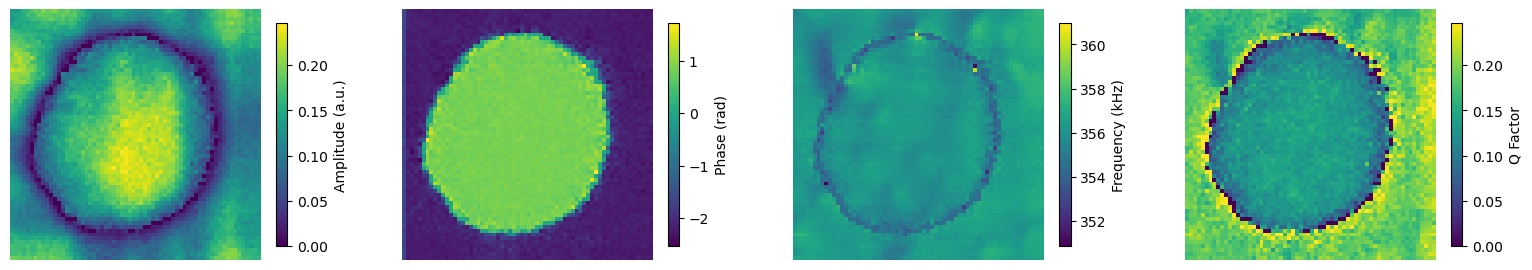

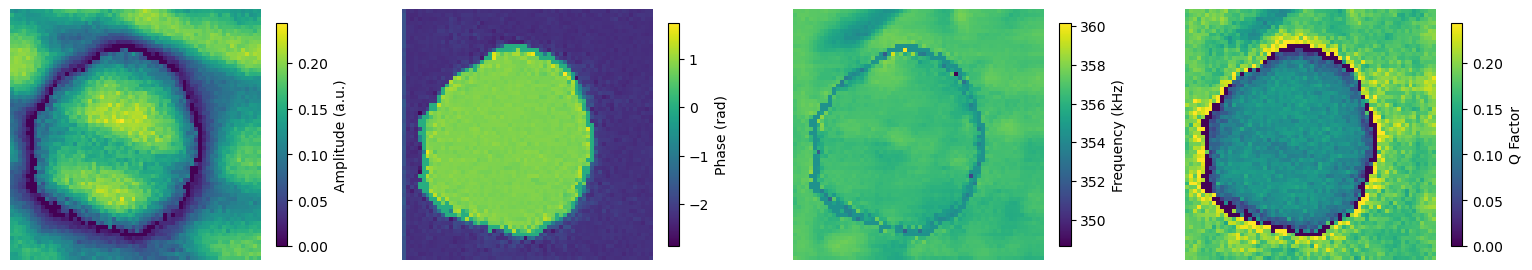

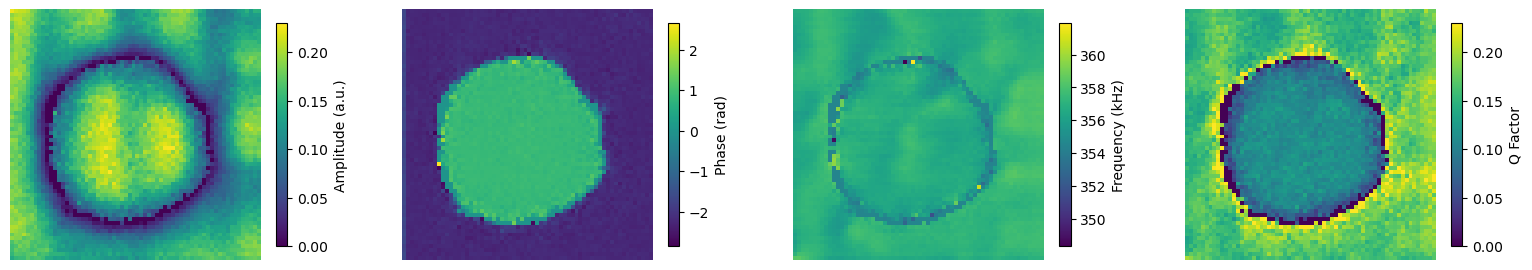

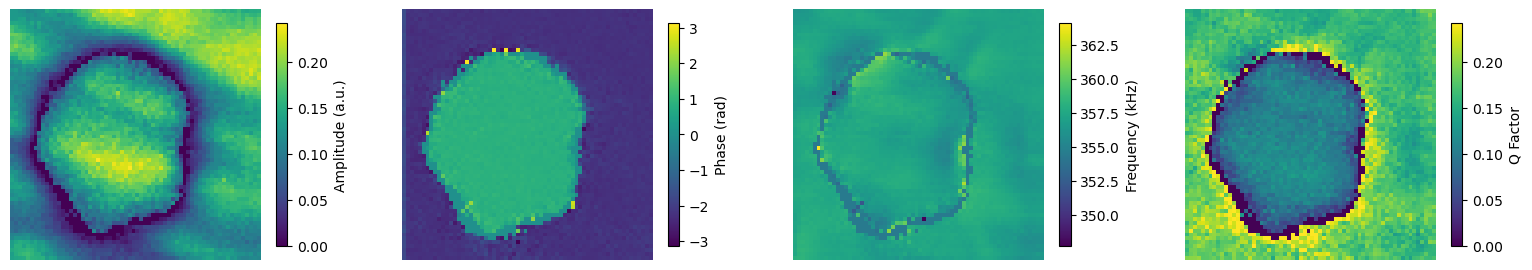

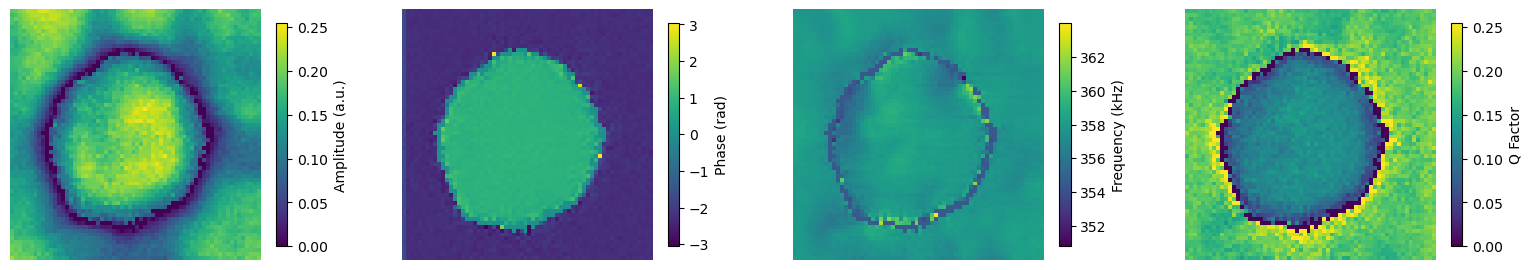

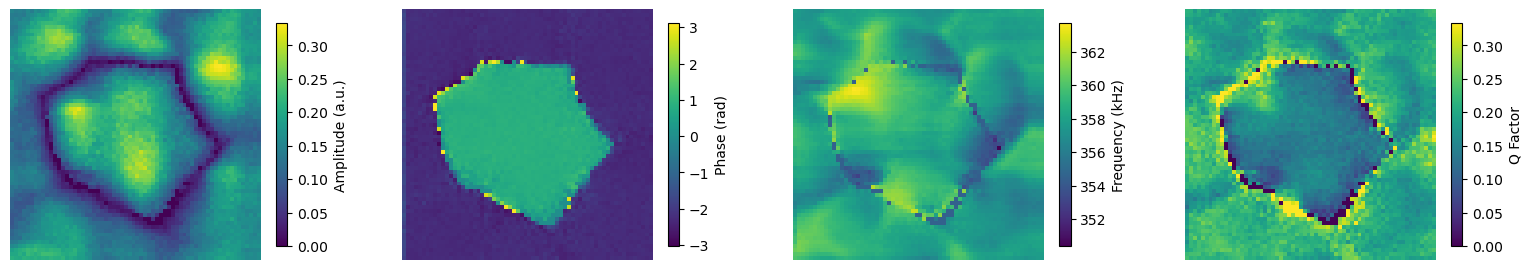

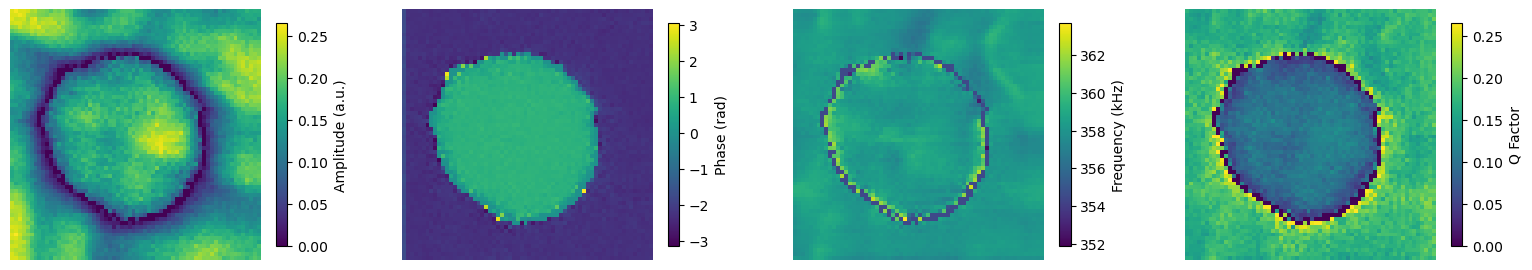

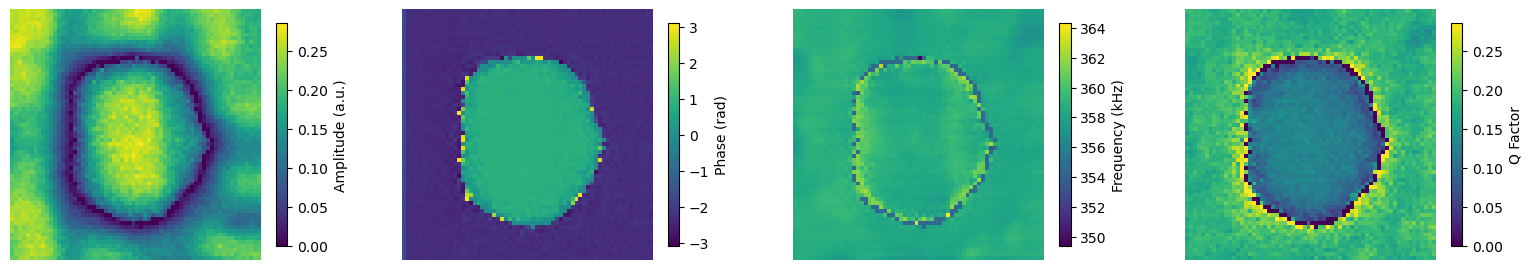

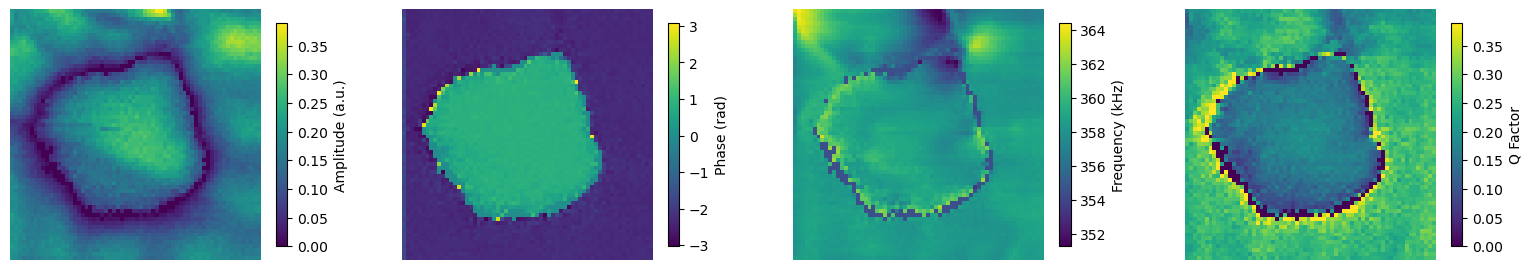

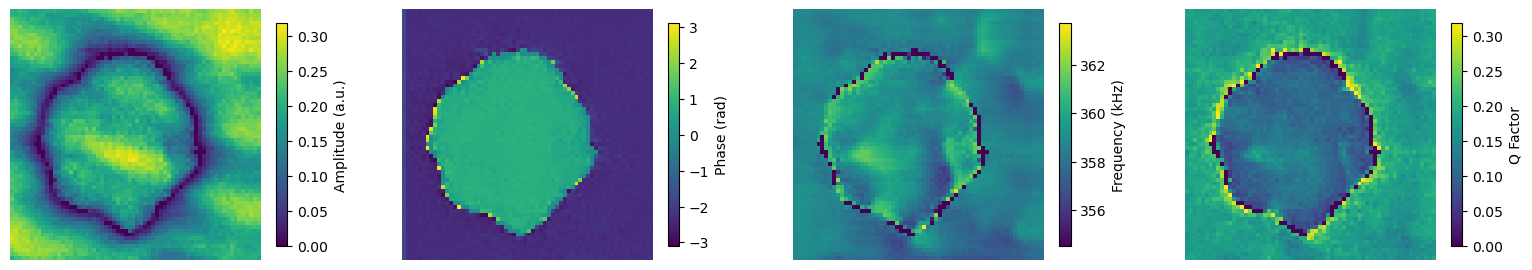

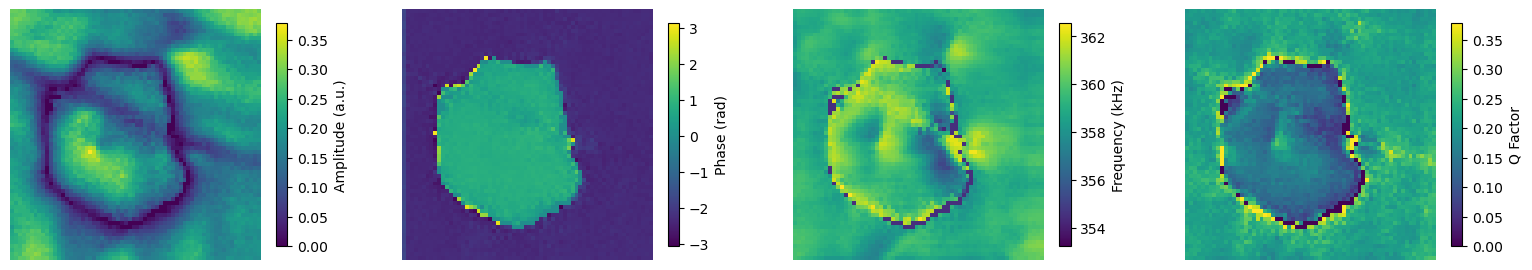

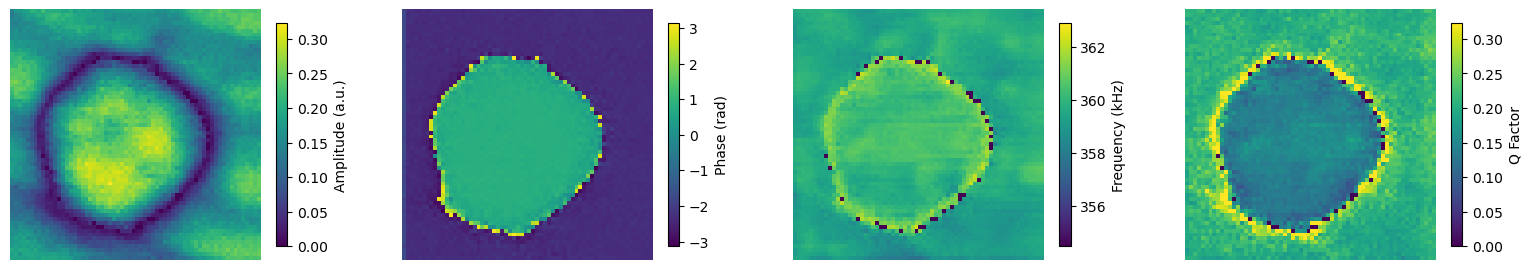

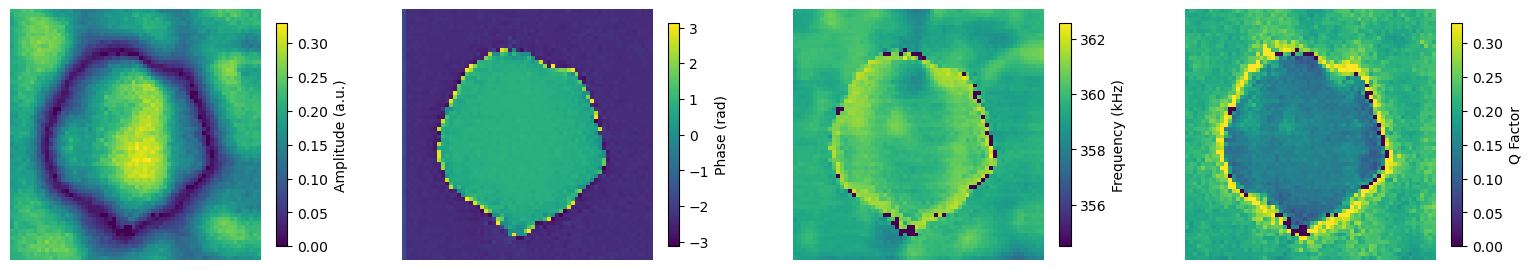

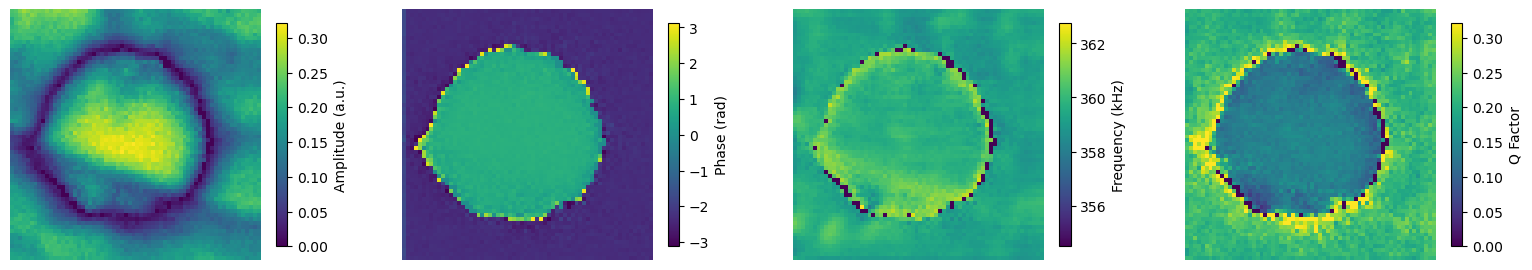

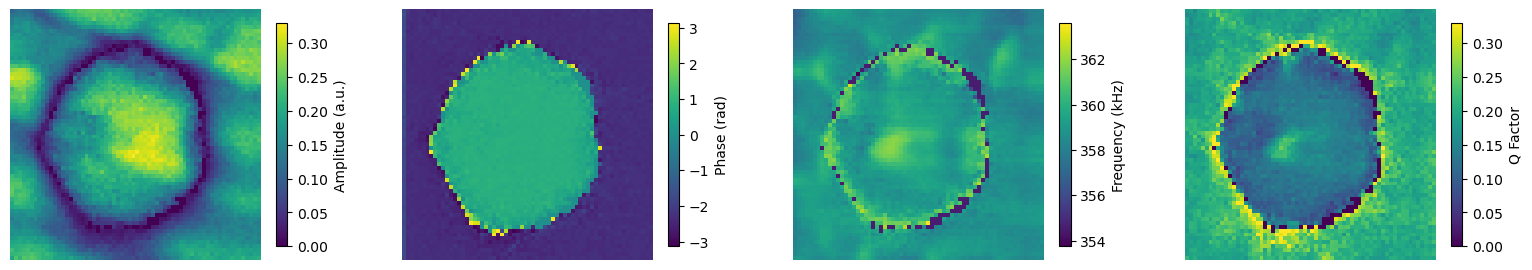

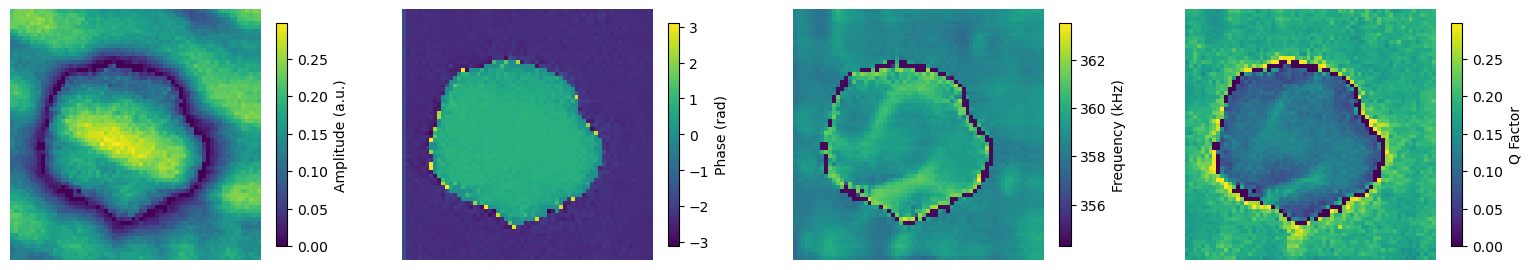

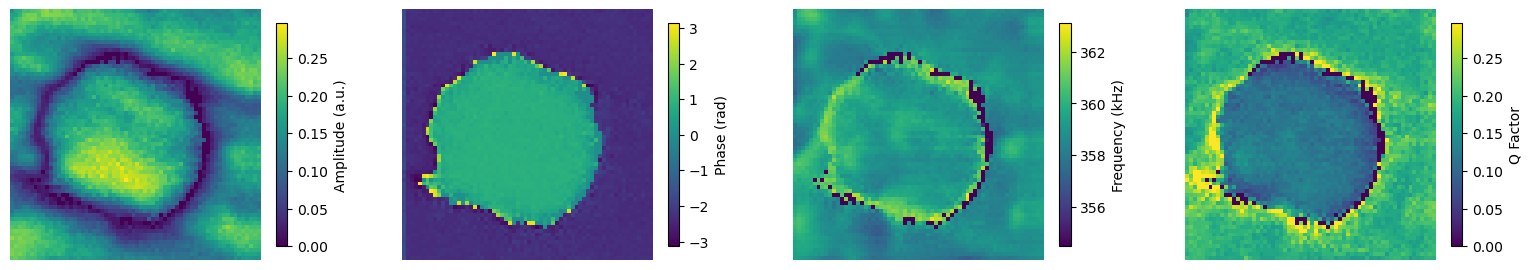

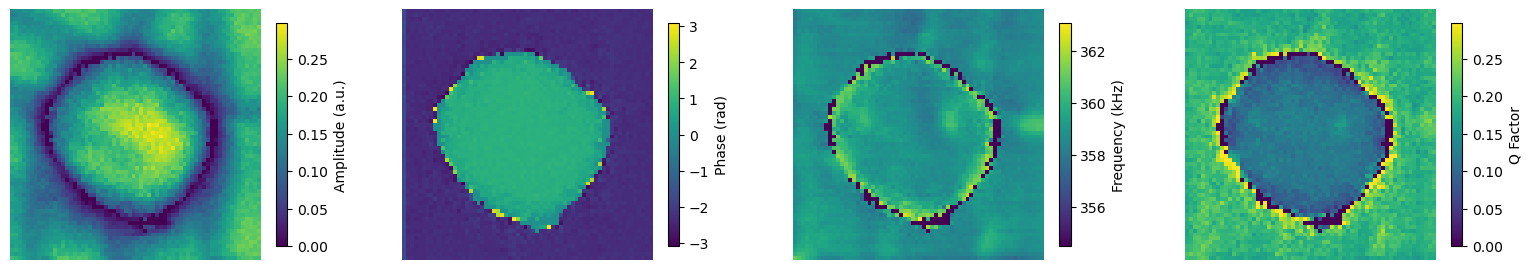

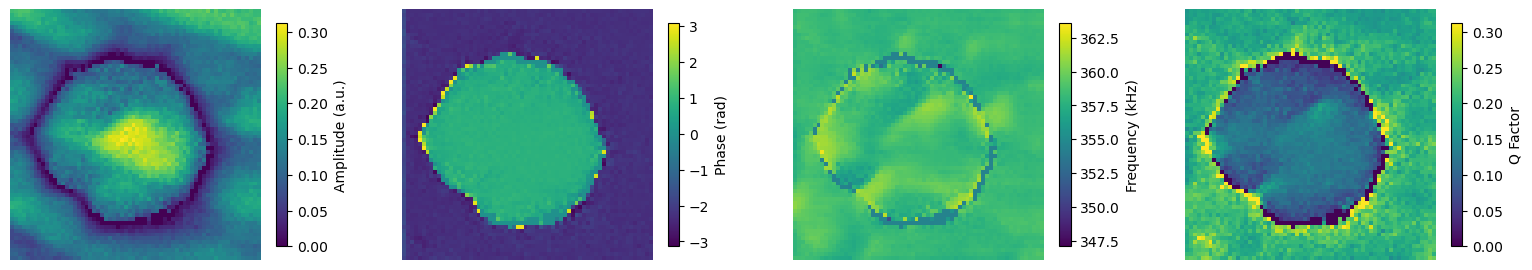

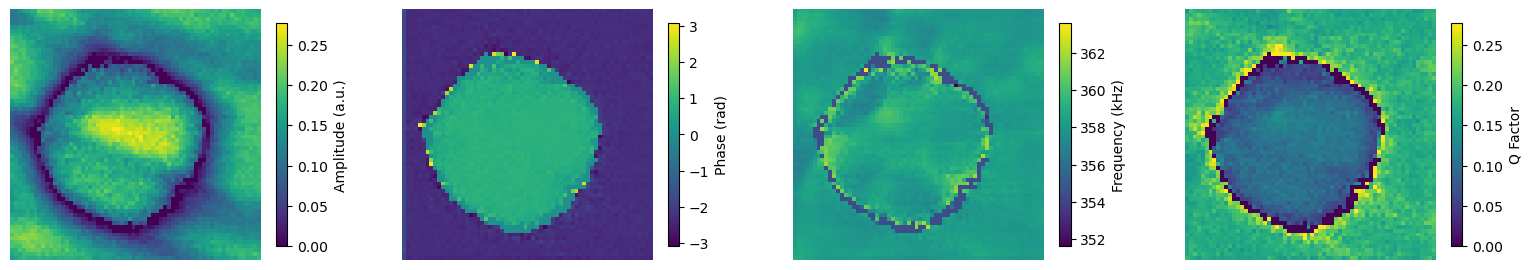

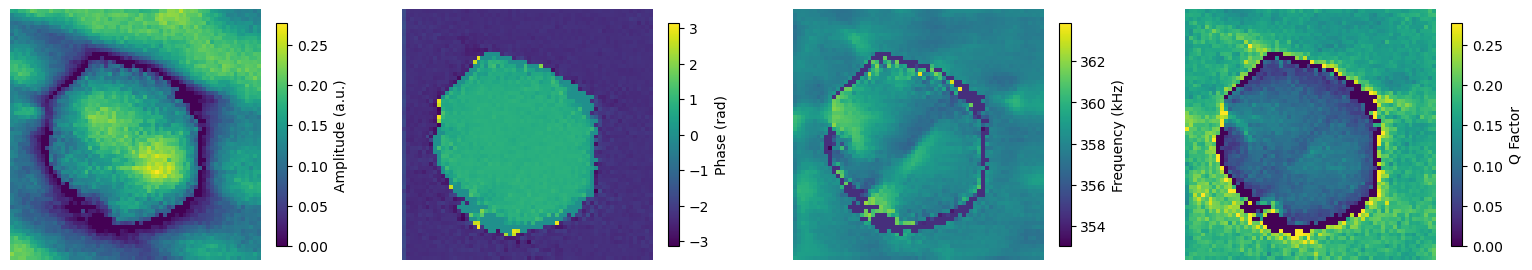

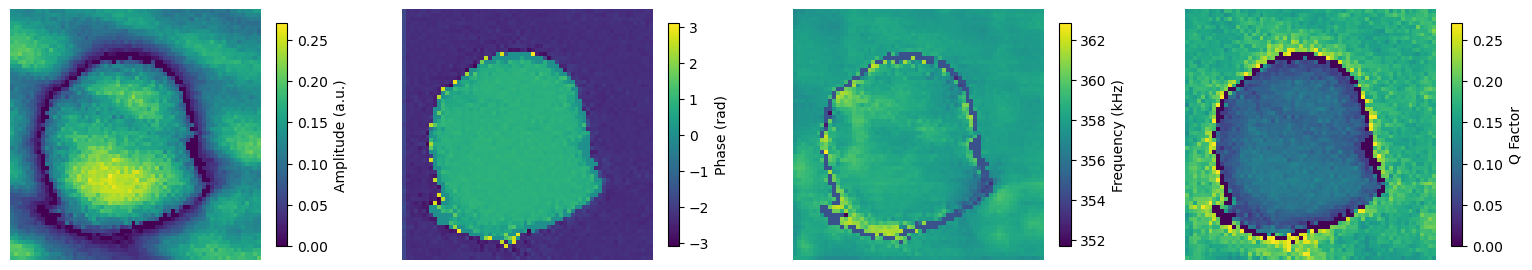

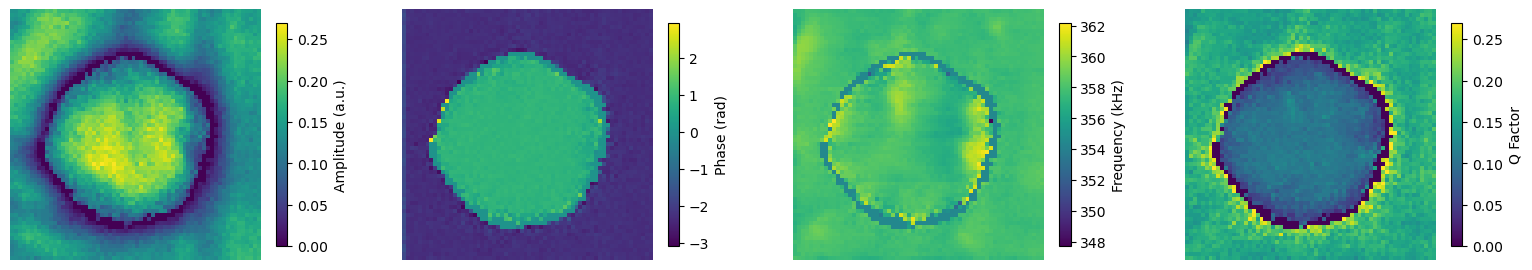

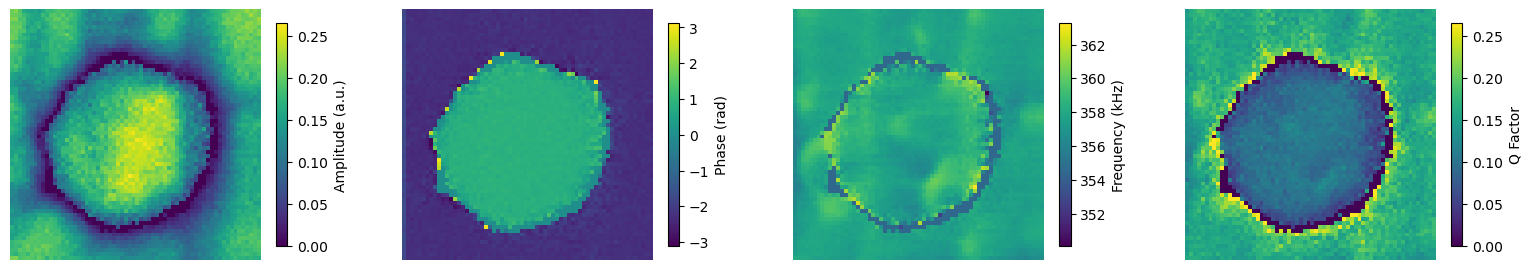

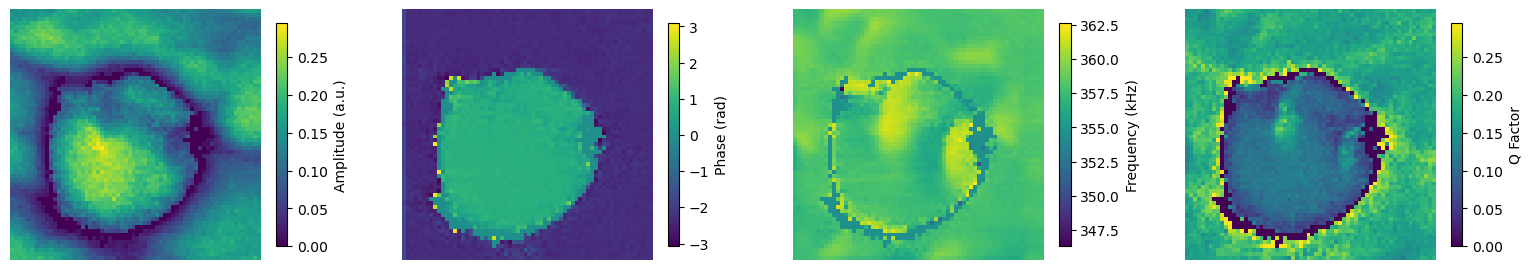

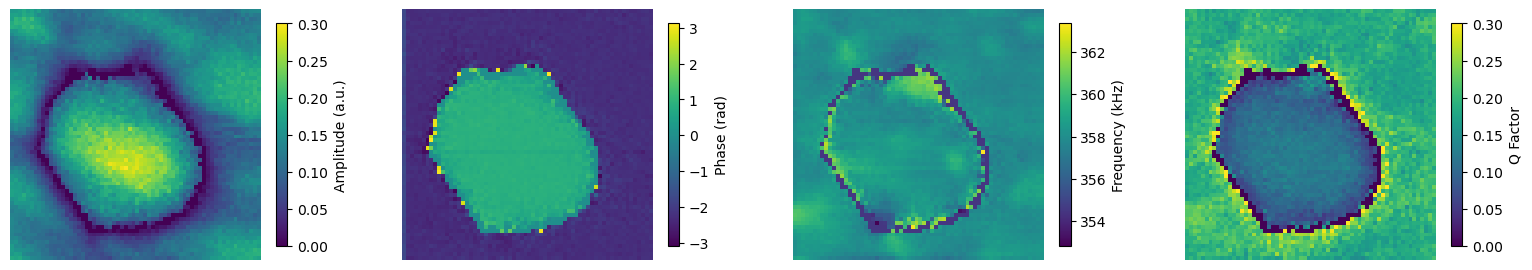

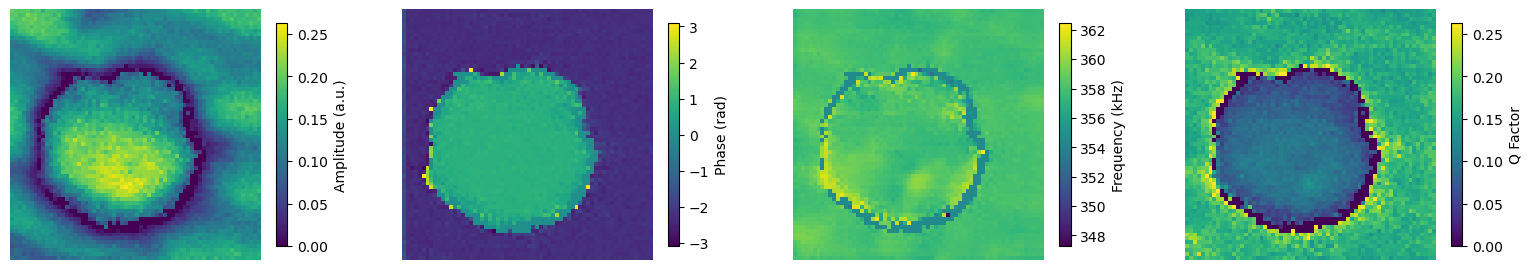

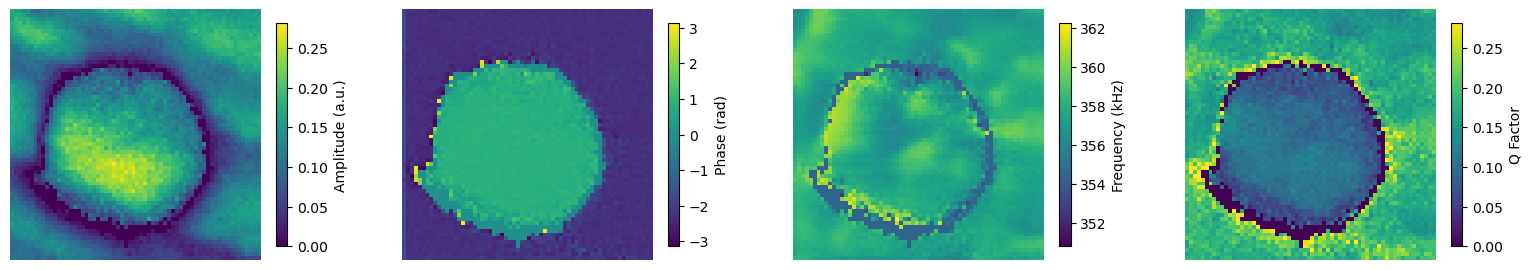

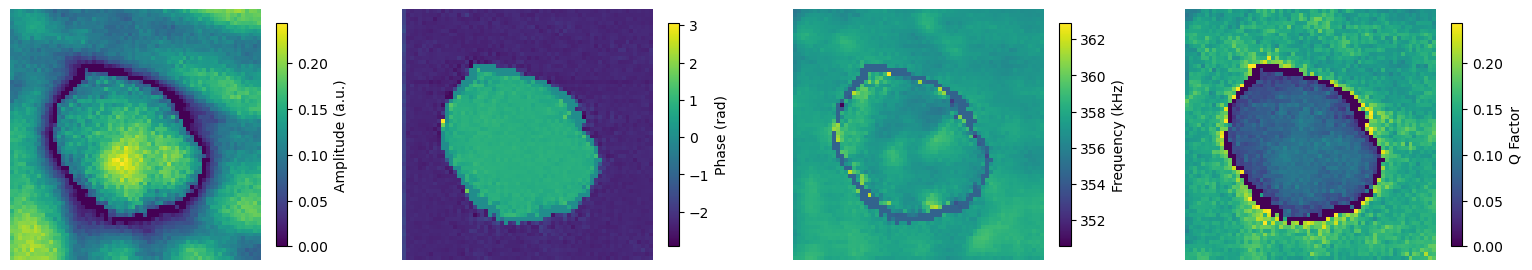

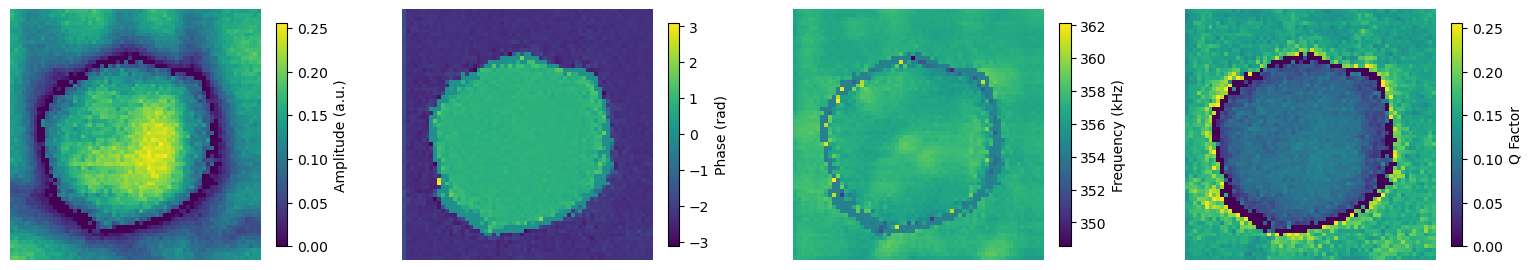

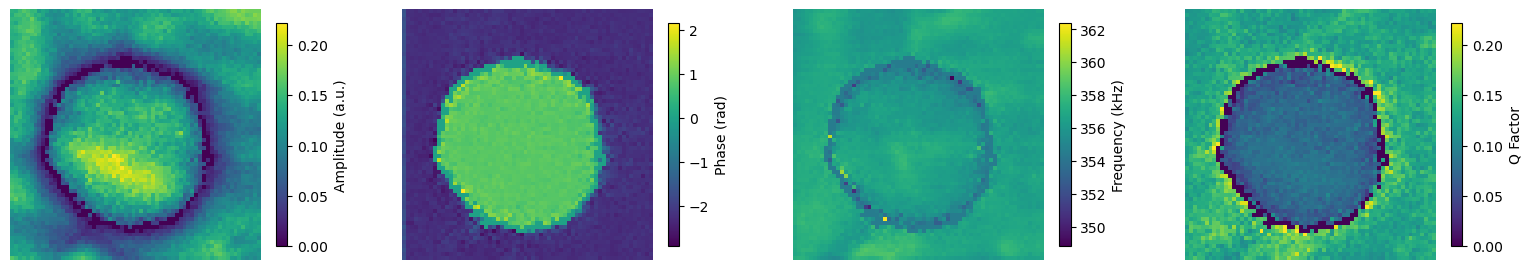

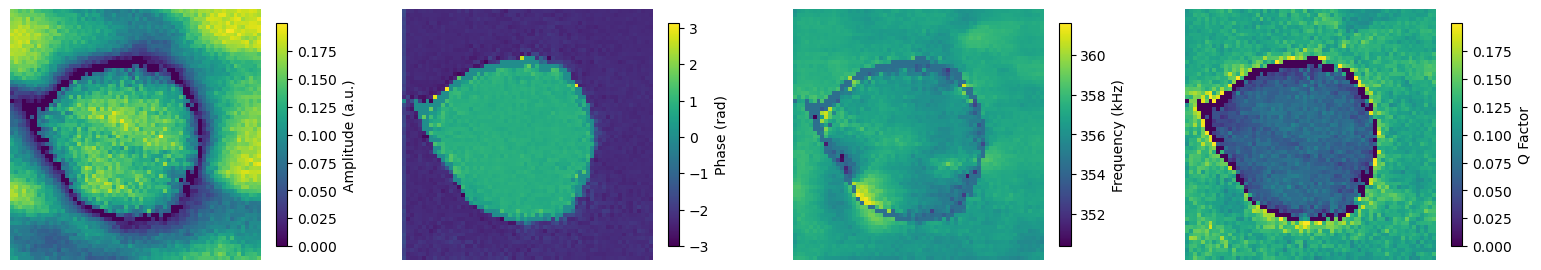

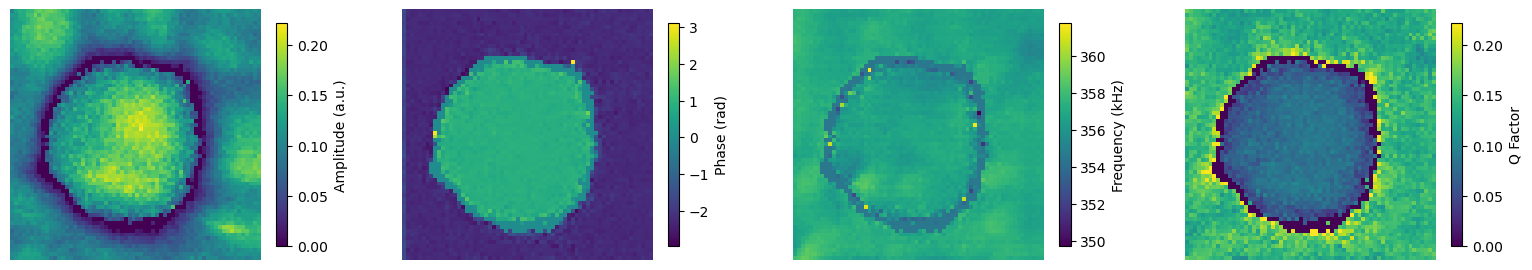

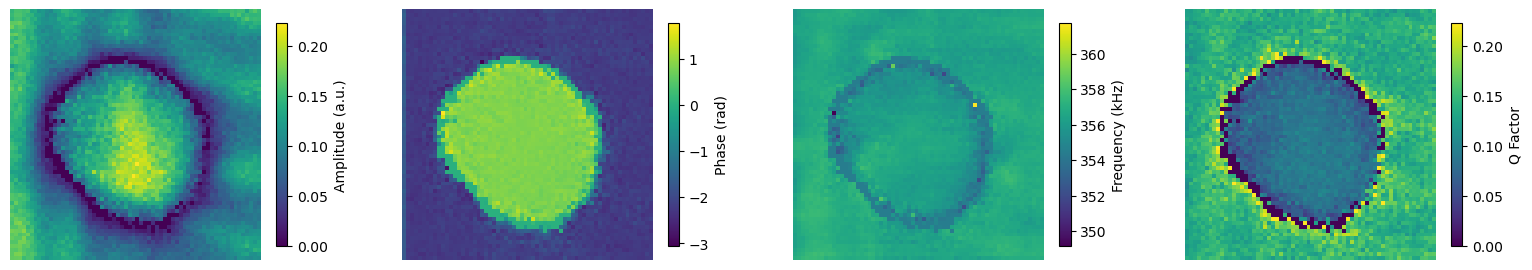

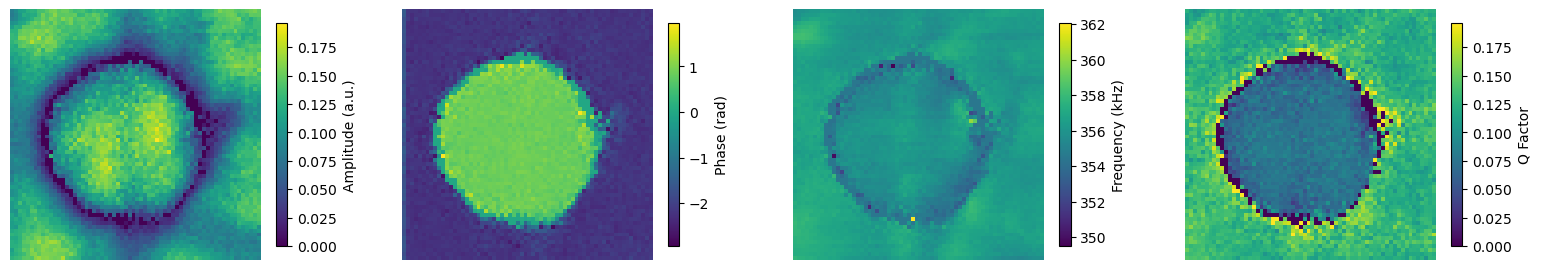

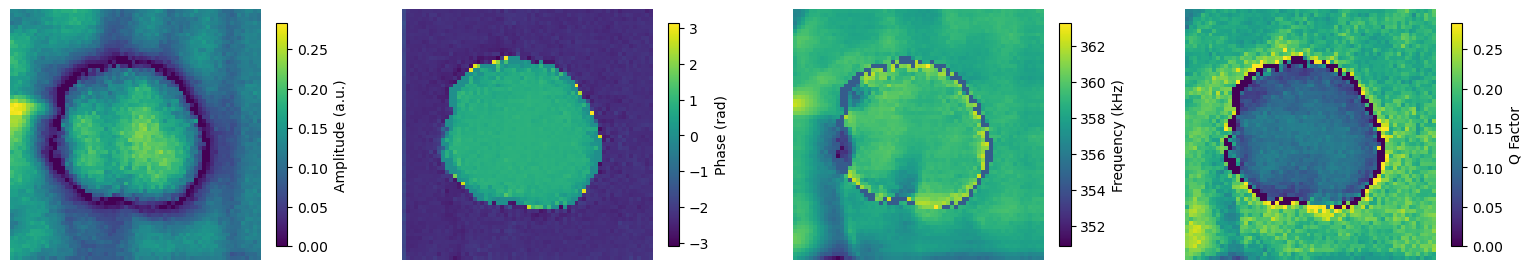

In [9]:
for i in range (count_imgs):

    fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi = 100)
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.99, wspace=0.25)
    cm = 'viridis'
    shrink = 0.6

    im0 = axs[0].imshow(amplitude[i, ]*1000, origin = "lower", interpolation='nearest', cmap=cm)
    fig.colorbar(im0, ax=axs[0], shrink = shrink, label = "Amplitude (a.u.)")
    axs[0].axis("off")

    im1 = axs[1].imshow(phase[i, ], origin = "lower", interpolation='nearest', cmap=cm)
    fig.colorbar(im1, ax=axs[1], shrink = shrink, label = "Phase (rad)")
    axs[1].axis("off")

    im2 = axs[2].imshow(frequency[i, ]/1000, origin = "lower", interpolation='nearest', cmap=cm)
    fig.colorbar(im2, ax=axs[2], shrink = shrink, label = "Frequency (kHz)")
    axs[2].axis("off")

    im3 = axs[3].imshow(qfactor[i, ], origin = "lower", vmin = 0, vmax = 250, interpolation='nearest', cmap=cm)
    fig.colorbar(im0, ax=axs[3], shrink = shrink, label = "Q Factor")
    axs[3].axis("off")
    
    plt.show()

Plot a specific channel together

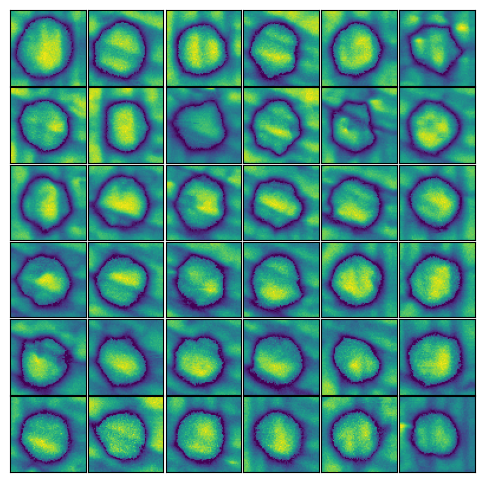

In [10]:
fig, axes = plt.subplots(num_y, num_x, figsize=(num_x, num_y),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.02, wspace=0.02))

for ax, i in zip(axes.flat, range(count_imgs)):
    ax.imshow(amplitude[i,], origin = "lower") # We are plotting amplitude now, you can change the channel to phase, frequency,etc

## Calculate domain size

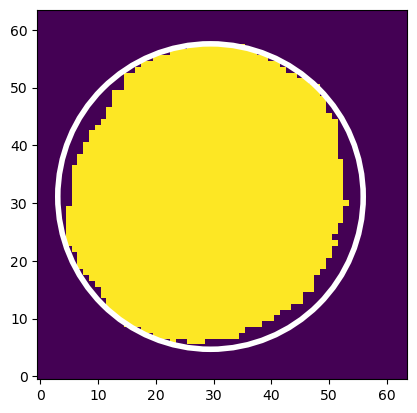

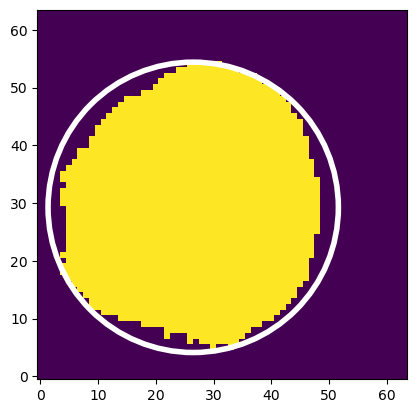

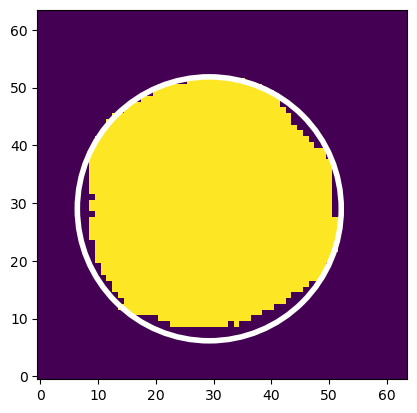

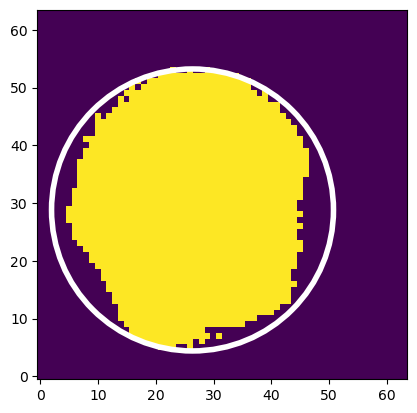

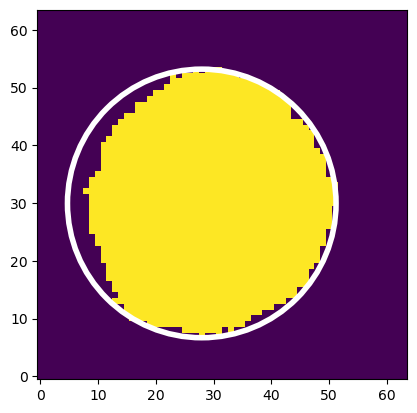

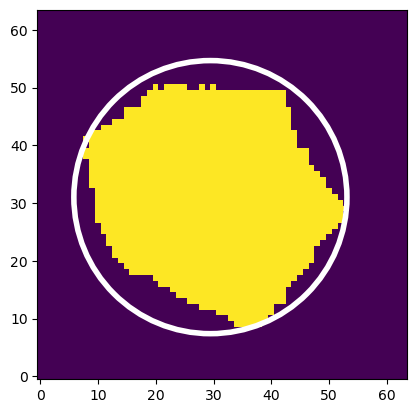

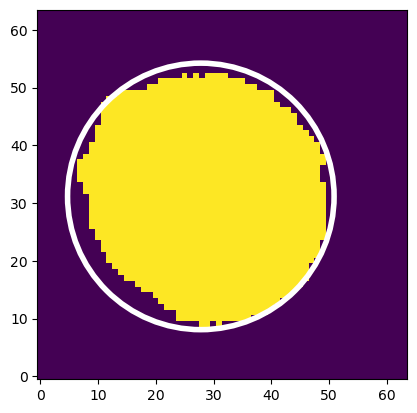

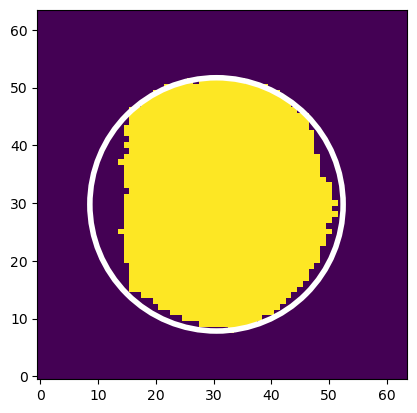

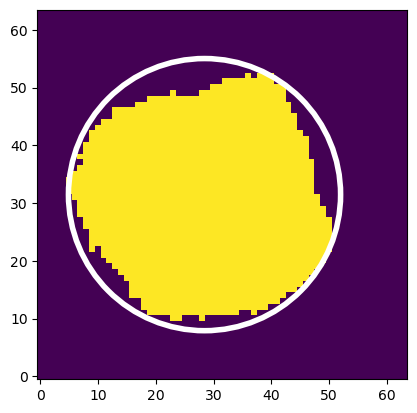

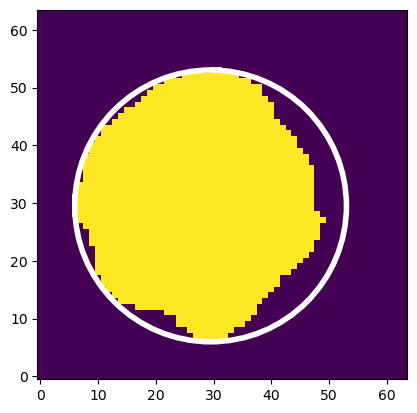

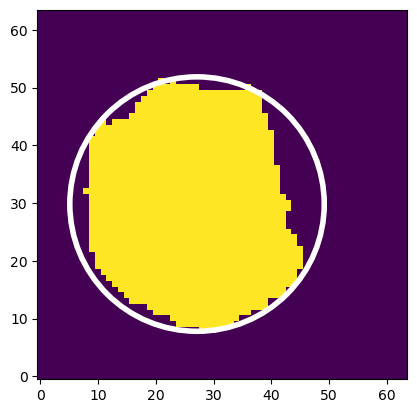

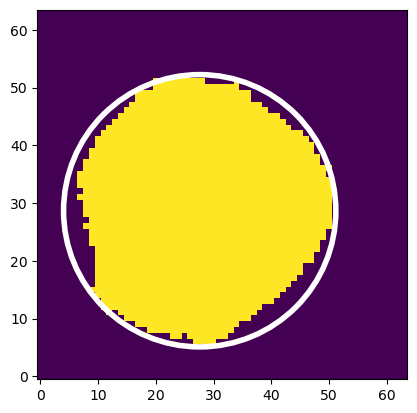

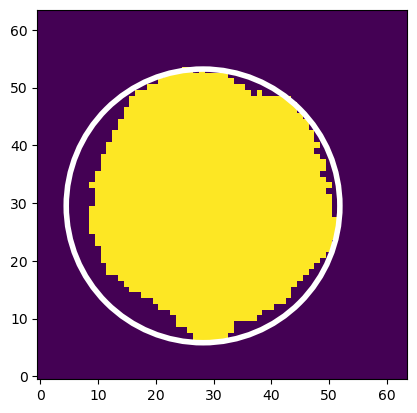

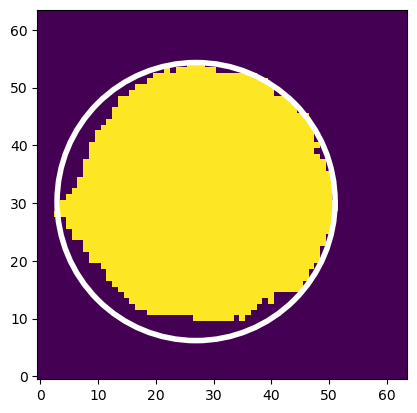

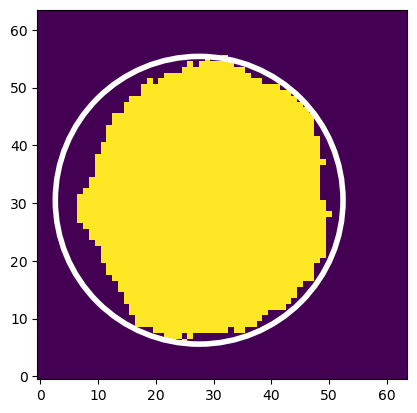

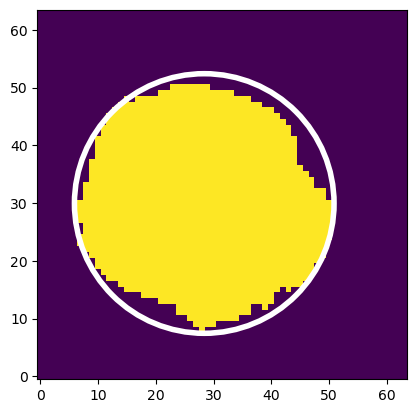

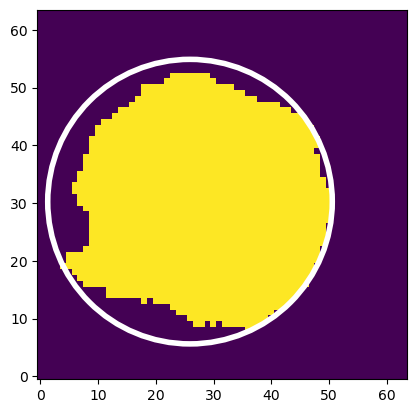

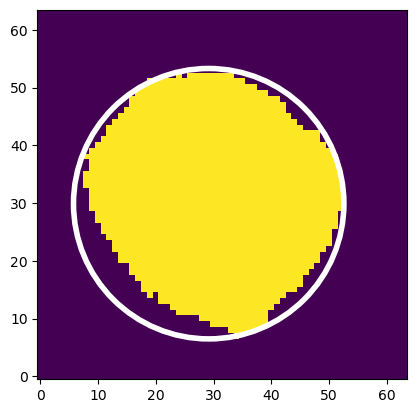

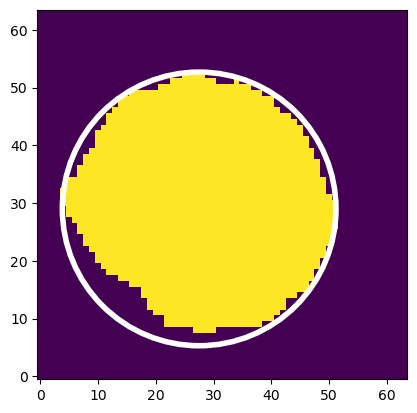

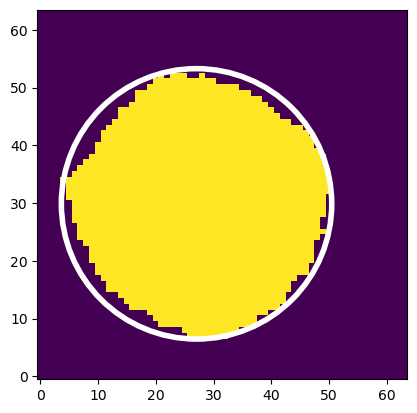

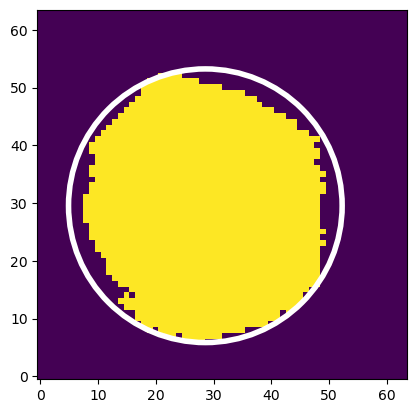

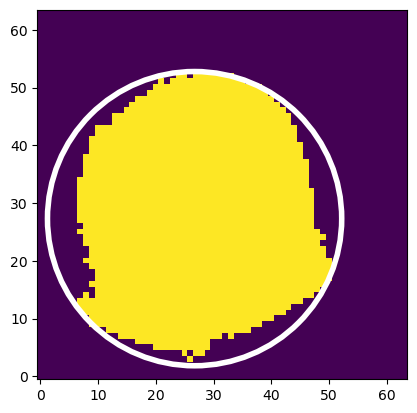

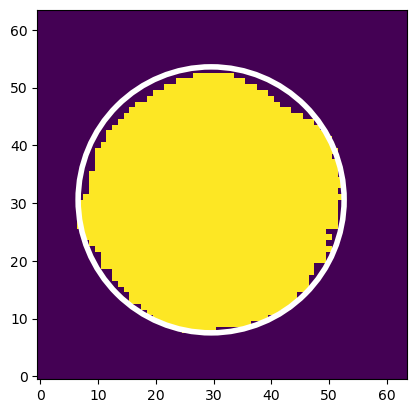

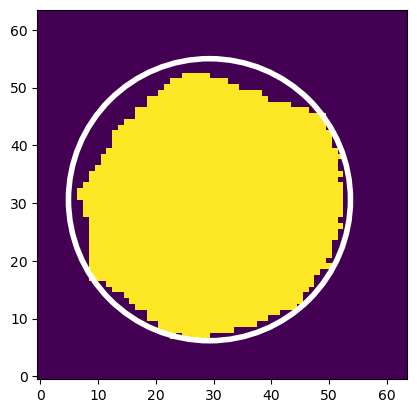

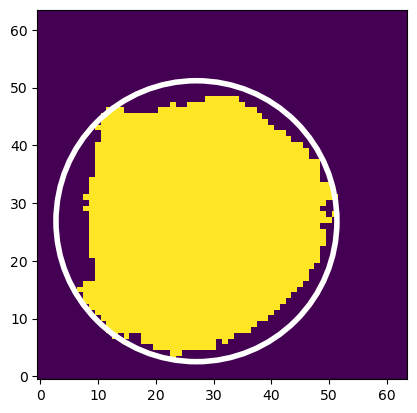

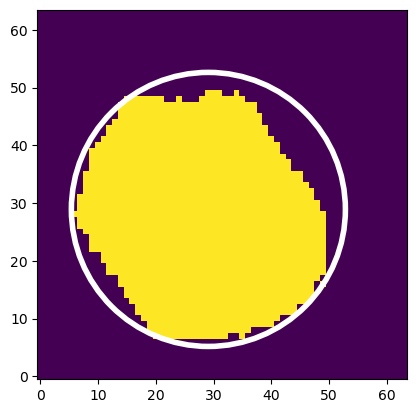

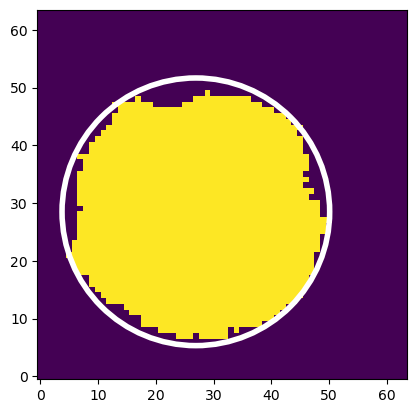

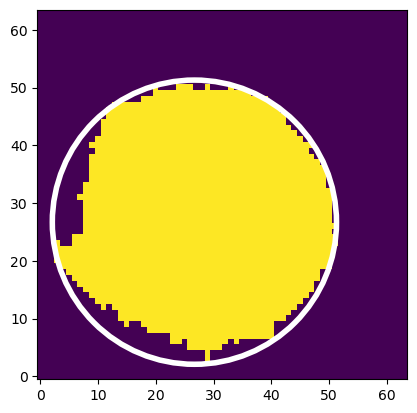

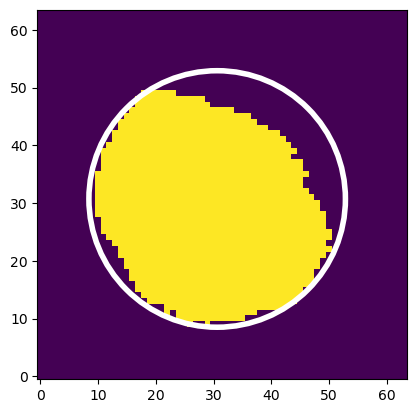

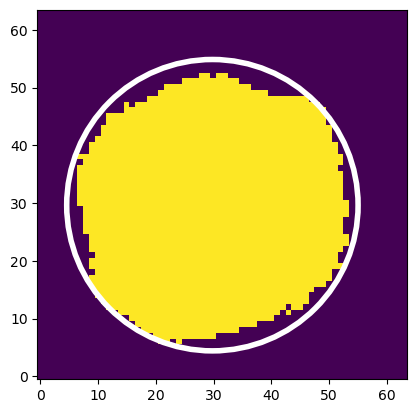

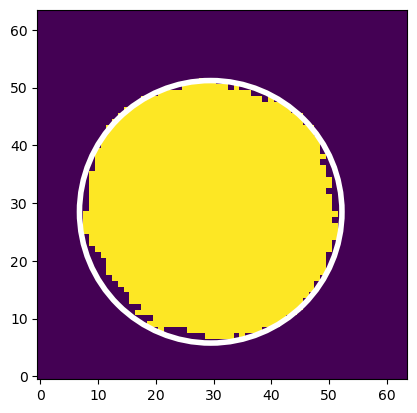

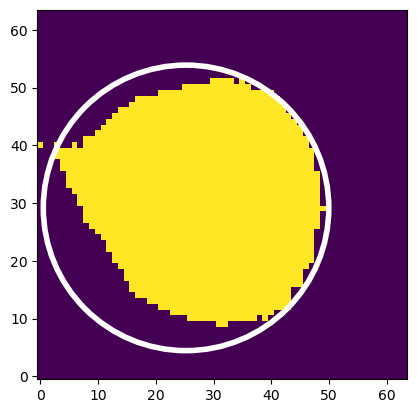

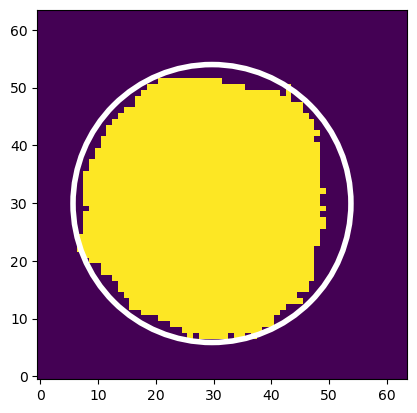

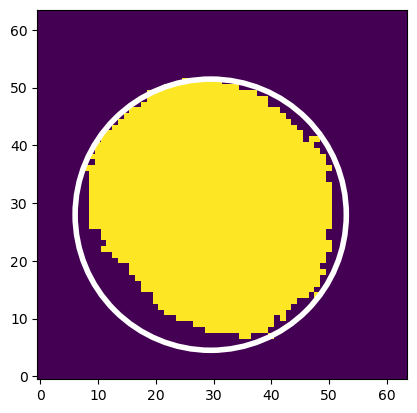

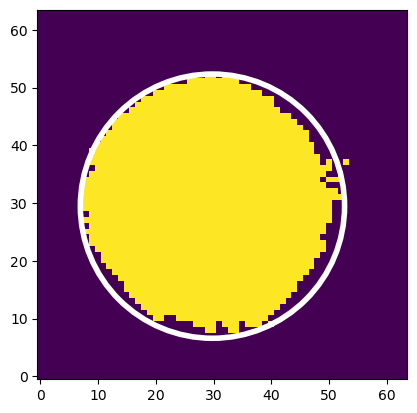

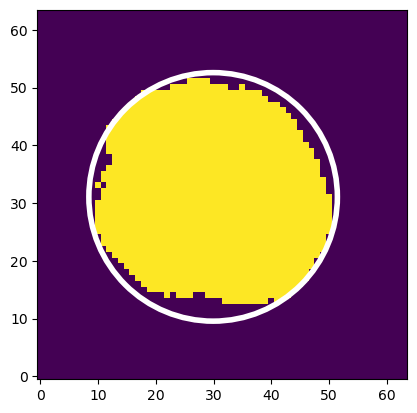

In [11]:
# create an array to save domain size
d_size = np.zeros(count_imgs)

# calculate domain size
for i in range (count_imgs):
    d_size[i] = domain_size (nor_phase[i,], 0.3)

In [12]:
# convert the unit of domain size to nm
dsize = d_size*250/64

Text(0.5, 1.0, 'Domain size pulsed by -8 V, 20 s')

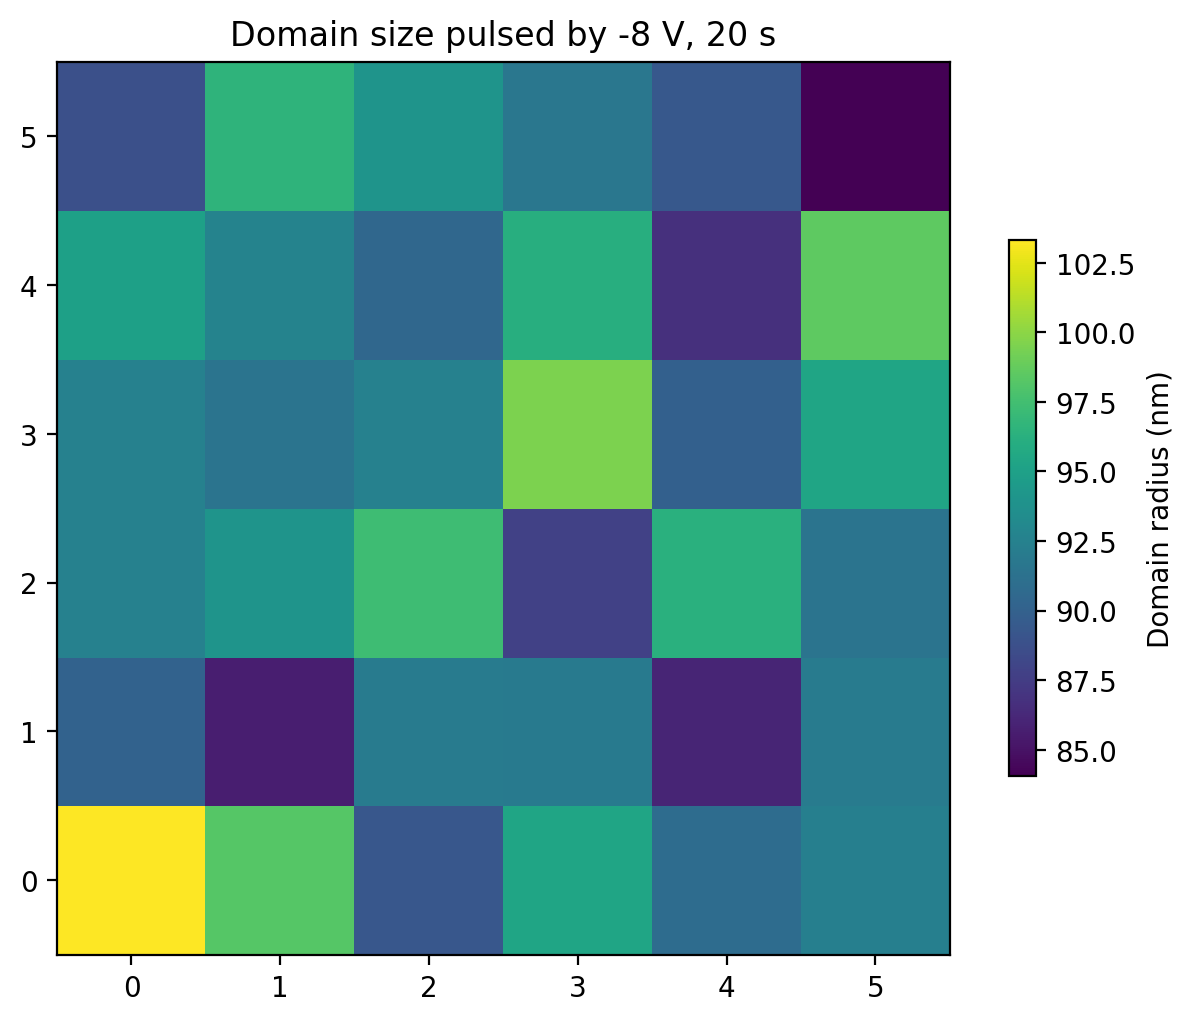

In [13]:
fig, axs = plt.subplots( dpi = 200)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.99, wspace=0.25)
cm = 'viridis'
im0 = axs.imshow(dsize.reshape(num_x, num_y), origin = "lower", interpolation='nearest', cmap=cm)
fig.colorbar(im0, ax=axs, shrink = shrink, label = "Domain radius (nm)")
axs.set_title("Domain size pulsed by -8 V, 20 s")